In [1]:
!pip install --upgrade e3nn
!pip install embreex
!pip install --upgrade trimesh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [16]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import e3nn
from e3nn import o3, io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from functools import partial, reduce

import trimesh
import math


device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cpu'

# https://github.com/googlecolab/colabtools/issues/1165
# import plotly.io
# plotly.io.renderers.default = "notebook"

device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'cpu'

In [3]:
!wget https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj

--2024-05-05 20:50:00--  https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj
Resolving graphics.stanford.edu (graphics.stanford.edu)... 171.67.77.70
Connecting to graphics.stanford.edu (graphics.stanford.edu)|171.67.77.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205917 (201K) [text/plain]
Saving to: ‘bunny.obj’

bunny.obj           100%[===================>] 201.09K   388KB/s    in 0.5s    

2024-05-05 20:50:01 (388 KB/s) - ‘bunny.obj’ saved [205917/205917]



In [4]:
def mesh_to_sgrid(res_beta: int, res_alpha: int, lmax: int, mesh: trimesh.Trimesh):
    # Create spherical tensor creator
    fromS2Grid = e3nn.o3.FromS2Grid((res_beta, res_alpha), lmax, normalization="integral")

    grid_coords = fromS2Grid.grid
    grid_coords_flat = grid_coords.reshape(-1, 3)

    # -- Calculate using grid -- #
    ray = trimesh.ray.ray_pyembree
    intersector = ray.RayMeshIntersector(mesh)
    index_tri, index_ray, loc = intersector.intersects_id(ray_origins=10 * grid_coords_flat, ray_directions=-grid_coords_flat,
                            multiple_hits=False, return_locations=True)

    # loc is the location of intersection point in world coordinate frame
    loc = torch.tensor(loc, dtype=torch.float32)
    distances = torch.norm(loc, dim=1)

    signal = distances.reshape(1, res_beta, res_alpha)
    sph_coeff = fromS2Grid(signal)

    return sph_coeff

def mesh_to_sphDeltas(lmax: int, mesh: trimesh.Trimesh, n_samples: int) -> torch.tensor:
    # -- Sample uniformly on the sphere -- #

    vectors = torch.normal(0, 1.0, (n_samples, 3))
    vectors = vectors / torch.linalg.norm(vectors, dim=1, keepdim=True)


    ray = trimesh.ray.ray_pyembree
    intersector = ray.RayMeshIntersector(mesh)
    index_tri, index_ray, loc = intersector.intersects_id(ray_origins=10 * vectors, ray_directions=-vectors,
                            multiple_hits=False, return_locations=True)

    x = torch.tensor(loc, dtype=torch.float32).reshape(-1, 3)

    sphten = e3nn.io.SphericalTensor(lmax, 1, 1)
    sph_coeff = e3nn.o3.spherical_harmonics(sphten, x, normalize=False)

    return sph_coeff


In [5]:
class SimpleShapeGridDataset(Dataset):
    def __init__(self, res_beta=100, res_alpha=51, lmax=11):
        self.shapes = []

        # just add a cube
        box_mesh = trimesh.creation.box([1, 1, 1])
        scoeff= mesh_to_sgrid(res_beta, res_alpha, lmax, box_mesh)
        self.shapes.append(scoeff)

    def __len__(self):
        return 1

    def __getitem__(self, item):
        return self.shapes[0]

dataset = SimpleShapeGridDataset()
data = next(iter(DataLoader(dataset, batch_size=1))).float()

In [9]:
# how does it look like in spherical harmonics?

sphten = io.SphericalTensor(11, 1, 1)
signal = data

fig = make_subplots(rows=1, cols=2, specs=[[{'is_3d': True} for j in range(2)] for i in range(1)])
# fig.add_trace(go.Scatter3d(x=0.12 * data[0, :, 0], y=0.12 * data[0, :, 1], z=0.12 * data[0, :, 2]), row=1, col=2)
fig.add_trace(go.Surface(sphten.plotly_surface(signal, radius=True)[0]), row=1, col=2)
# fig.add_trace(go.Scatter3d(x=data[0, :, 0], y=data[0, :, 1], z=data[0, :, 2]), row=1, col=1)
fig.show()


In [10]:
class SelfTP(nn.Module):
    def __init__(self, irreps_in, irreps_out, batch_norm=True):
        super(SelfTP, self).__init__()

        self.tp = o3.FullyConnectedTensorProduct(irreps_in1=irreps_in, irreps_in2=irreps_in, irreps_out=irreps_out)
        self.bn = e3nn.nn.BatchNorm(irreps_out)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.tp(x, x)
        if self.batch_norm:
            x = self.bn(x)
        return x

class EncoderDecoder(nn.Module):
    def __init__(self, lmax):
        super(EncoderDecoder, self).__init__()

        self.irrep_layer = []
        tw = 1
        # lmax = 5
        for l in range(lmax, 0, -1): # last one sould be lmax=1
            irreps = io.SphericalTensor(lmax=l, p_arg=1, p_val=1)
            irreps = irreps * tw
            irreps = (irreps.sort())[0]
            irreps = irreps.simplify()
            self.irrep_layer.append(irreps)
            tw *= 2

        # todo should the last layer have batch norm?
        # todo use fully connected tensor product?
        self.encoder = nn.Sequential(*[
            SelfTP(irreps_in=self.irrep_layer[i], irreps_out=self.irrep_layer[i+1], batch_norm=(i != len(self.irrep_layer)-2))
            for i in range(len(self.irrep_layer)-1)
        ])

        # todo is the information bottleneck limited enough?
        self.decoder = nn.Sequential(*[
            SelfTP(irreps_in=self.irrep_layer[i+1], irreps_out=self.irrep_layer[i], batch_norm=(i != 0))
            for i in range(len(self.irrep_layer)-2, -1, -1)
        ])

    def forward(self, x):
        # inp = o3.spherical_harmonics(l=self.irrep_layer[0], x=points, normalize=False).mean(dim=1) # todo fix the normalization later
        latent = self.encoder(x)
        out = self.decoder(latent)
        return x, latent, out

print("number of parameters = ", sum([np.prod(x.shape) for x in EncoderDecoder(7).parameters()]))

/home/elchun/miniconda3/envs/6s966/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.



number of parameters =  2040033


In [11]:
class WeightedLoss(nn.Module):
    def __init__(self, lmax):
        super(WeightedLoss, self).__init__()
        self.lmax = lmax

    def forward(self, input, target):
        loss = 0
        start_idx = 0
        for l in range(self.lmax):
            end_idx = start_idx + 2 * l + 1
            weight = 1 / torch.mean(target[..., start_idx:end_idx])
            l_loss = torch.nn.functional.mse_loss(input[..., start_idx:end_idx], target[..., start_idx:end_idx]) * weight
            loss += l_loss
            # torch.exp(torch.tensor(-l))
            start_idx = end_idx
        return loss

class LogLoss(nn.Module):
    def __init__(self, lmax):
        super(LogLoss, self).__init__()
        self.lmax = lmax

    def forward(self, input, target):
        input_log = torch.log(input / 10)
        target_log = torch.log(target / 10)
        return torch.nn.functional.mse_loss(input, target)
        # loss = 0
        # start_idx = 0
        # for l in range(self.lmax):
        #     end_idx = start_idx + 2 * l + 1
        #     loss += torch.nn.functional.mse_loss(input_log[..., start_idx:end_idx], target_log[..., start_idx:end_idx])
        #     start_idx = end_idx
        # return loss

class GridLoss(nn.Module):
    def __init__(self, lmax, res=100):
        super(GridLoss, self).__init__()

        res_beta = 100
        res_alpha = 101
        normalization = "integral"
        self.m = e3nn.o3.ToS2Grid(lmax, (res_beta, res_alpha), normalization)

    def forward(self, input, target):
        input_s2grid = self.m(input)
        target_s2grid = self.m(target)
        # return torch.nn.functional.mse_loss(input_s2grid, target_s2grid, reduction="sum")
        return torch.nn.functional.l1_loss(input_s2grid, target_s2grid, reduction="sum")
        # input_s2grid = self.sphten.signal_on_grid(input, self.res, self.normalization)
        # input_s2grid = input_s2grid.grid
        # input_s2values = input_s2grid.values
        # print(input_s2grid.shape)
        # print(input_s2values.shape)




lmax = 5
loss_fn = GridLoss(lmax, 100).to(device)
inp = torch.rand((1, 1, 36))
target = torch.rand((1, 1, 36))
print(inp)
loss_fn(inp.to(device), target.to(device))

tensor([[[0.6582, 0.6907, 0.6613, 0.2394, 0.7497, 0.3391, 0.1524, 0.5481,
          0.5507, 0.0655, 0.6344, 0.6491, 0.1521, 0.7734, 0.9111, 0.5715,
          0.8815, 0.8431, 0.1970, 0.4955, 0.3818, 0.6528, 0.8157, 0.3502,
          0.0454, 0.9185, 0.6510, 0.1383, 0.5407, 0.3086, 0.4052, 0.1096,
          0.4202, 0.7045, 0.8449, 0.0044]]])


tensor(5726.5518, device='cuda:0')

In [31]:
lmax = 6
epochs = 2000
BATCH_SIZE = 1
torch.manual_seed(0)

dataset = SimpleShapeGridDataset(lmax=lmax)  # lmax = 5
model = EncoderDecoder(lmax).to(device)   # lmax is also 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # was 0.0001
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1) # todo interesting apparently you shouldn't change rl
# loss_fn = torch.nn.HuberLoss(reduction='mean')
# loss_fn = WeightedLoss(lmax)
# loss_fn = LogLoss(lmax)
loss_fn = GridLoss(lmax).to(device)


dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
# single_data = next(iter(dataloader)).float().to(device)

pbar = tqdm(range(epochs))
losses = []
done = False
for i in pbar:
    for data in dataloader:
        data = data.float().to(device)
        inp, latent, out = model(data)
        # loss = loss_fn(inp, out)
        loss = loss_fn(out, inp)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        max_grad = max([torch.linalg.norm(p.grad).item() for p in model.parameters() if p.grad is not None])
        # pbar.set_description(f'Epoch {i+1} Loss: {loss.item():.8f} Lr={scheduler.get_last_lr()[0]} MaxGrad={max_grad:.4f}')
        pbar.set_description(f'Epoch {i+1} Loss: {loss.item():.8f} MaxGrad={max_grad:.4f}')
        losses.append(loss.item())

        # # Early stopping
        if np.mean(losses[-10:]) < 100:
            print("Stopped at epoch: ", i)
            done = True
            break

    if done:
        break



    # scheduler.step()

plt.plot(losses)
plt.figure()
plt.plot(losses[50:])
plt.figure()
plt.plot(losses[100:])

  0%|          | 0/2000 [00:00<?, ?it/s]

Stopped at epoch:  710
Stopped at epoch:  712
Stopped at epoch:  715
Stopped at epoch:  807
Stopped at epoch:  808
Stopped at epoch:  809
Stopped at epoch:  810
Stopped at epoch:  811
Stopped at epoch:  812
Stopped at epoch:  813
Stopped at epoch:  882
Stopped at epoch:  883
Stopped at epoch:  884
Stopped at epoch:  885
Stopped at epoch:  886
Stopped at epoch:  887
Stopped at epoch:  888
Stopped at epoch:  889
Stopped at epoch:  890
Stopped at epoch:  891
Stopped at epoch:  892
Stopped at epoch:  893
Stopped at epoch:  894
Stopped at epoch:  895
Stopped at epoch:  896
Stopped at epoch:  897
Stopped at epoch:  898
Stopped at epoch:  899
Stopped at epoch:  900
Stopped at epoch:  901
Stopped at epoch:  902
Stopped at epoch:  903
Stopped at epoch:  904
Stopped at epoch:  905
Stopped at epoch:  906
Stopped at epoch:  907
Stopped at epoch:  908


KeyboardInterrupt: 

In [32]:
single_data = next(iter(dataloader)).float().to(device)

inp, latent, out = model(single_data)
inp = inp.cpu().detach()
latent = latent.cpu().detach()
out = out.cpu().detach()

loss_fn = loss_fn.cpu()

print('loss', loss_fn(inp, out))
print('L-inf loss', torch.max(torch.abs(inp - out)))

lmax = 6 # fixed for this spherical tensor
sphten = io.SphericalTensor(lmax, 1, 1)
fig = make_subplots(rows=1, cols=2, specs=[[{'is_3d': True} for j in range(2)] for i in range(1)])
fig.add_trace(go.Surface(sphten.plotly_surface(out, radius=True)[0]), row=1, col=1)
fig.add_trace(go.Surface(sphten.plotly_surface(inp, radius=True)[0]), row=1, col=2)

loss tensor(75.6072)
L-inf loss tensor(0.0138)


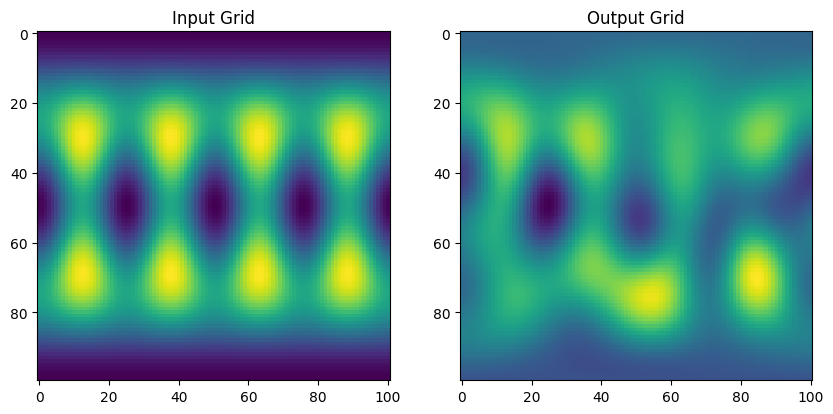

tensor(0.0033)


In [14]:
inp_grid = loss_fn.m(inp)
out_grid = loss_fn.m(out)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Creating subplots with 1 row and 2 columns

# Plotting the first image in the first subplot
axs[0].imshow(inp_grid[0, 0, :, :])
axs[0].set_title('Input Grid')

# Plotting the second image in the second subplot
axs[1].imshow(out_grid[0, 0, :, :])
axs[1].set_title('Output Grid')

plt.show()

print(torch.nn.functional.mse_loss(out_grid, inp_grid))

In [27]:
print(out_grid)
print(inp_grid)

tensor([[[[0.5184, 0.5184, 0.5184,  ..., 0.5184, 0.5184, 0.5184],
          [0.5198, 0.5198, 0.5198,  ..., 0.5198, 0.5198, 0.5198],
          [0.5227, 0.5226, 0.5226,  ..., 0.5225, 0.5226, 0.5226],
          ...,
          [0.5244, 0.5243, 0.5243,  ..., 0.5242, 0.5243, 0.5243],
          [0.5214, 0.5214, 0.5214,  ..., 0.5214, 0.5214, 0.5214],
          [0.5199, 0.5199, 0.5199,  ..., 0.5199, 0.5199, 0.5199]]]])
tensor([[[[0.4495, 0.4495, 0.4495,  ..., 0.4495, 0.4495, 0.4495],
          [0.4511, 0.4511, 0.4511,  ..., 0.4511, 0.4511, 0.4511],
          [0.4543, 0.4543, 0.4543,  ..., 0.4543, 0.4543, 0.4543],
          ...,
          [0.4543, 0.4543, 0.4543,  ..., 0.4543, 0.4543, 0.4543],
          [0.4511, 0.4511, 0.4511,  ..., 0.4511, 0.4511, 0.4511],
          [0.4495, 0.4495, 0.4495,  ..., 0.4495, 0.4495, 0.4495]]]])


In [15]:
print("input: ", inp)
print("output: ", out)

input:  tensor([[[ 2.1647e+00,  2.1484e-08, -5.5064e-08, -1.0480e-03, -1.1058e-08,
          -4.4527e-09,  4.6350e-05, -5.0591e-09, -1.8601e-05,  1.0430e-08,
           2.0151e-09, -7.8187e-09,  3.3411e-08,  3.9087e-04,  4.4520e-09,
           1.3348e-03,  4.2719e-08,  5.2173e-10, -4.8042e-09, -4.7762e-09,
          -1.9068e-01,  3.6398e-09,  1.8799e-05, -1.7754e-09, -1.6103e-01,
          -2.0354e-08, -6.9966e-09,  8.2139e-09,  1.4898e-10, -2.9089e-09,
           1.4435e-08,  1.1625e-04,  1.1498e-09, -6.5016e-05, -2.7067e-09,
           9.1782e-04]]])
output:  tensor([[[ 1.6704e+00,  7.3385e-03,  1.2586e-03, -1.8303e-02,  2.1464e-02,
          -1.5194e-04,  1.8264e-01,  3.1708e-02, -3.1653e-01, -7.6269e-03,
           2.4398e-04,  1.9689e-03, -1.0685e-02,  2.7232e-01,  1.3796e-02,
          -3.5177e-01, -1.6504e-02,  2.3467e-04,  6.2387e-03, -8.8516e-05,
          -2.0324e-01,  3.2657e-02,  3.0297e-01, -2.8801e-02, -4.0077e-01,
           2.4515e-02,  7.5340e-06, -1.0964e-02, -3.8725e

In [ ]:






res_beta = 1000
res_alpha = 501
lmax = 11
box_mesh = trimesh.creation.box([1, 1, 1])
capsule_mesh = trimesh.creation.capsule(0.5, 0.6)

# Load stanford bunny
bunny_mesh = trimesh.load("bunny.obj")
min_bound, max_bound = bunny_mesh.bounds
extents = max_bound-min_bound

center = (min_bound + max_bound) / 2
T = trimesh.transformations.translation_matrix(-center)
bunny_mesh.apply_transform(T)

scale = 1 / max(extents)
bunny_mesh.apply_scale(scale)



# transform = np.eye(4)
# mesh = trimesh.creation.icosphere(2, 1)

# -- Calculate single spherical harmonic -- #
scoeff1 = mesh_to_sgrid(res_beta, res_alpha, lmax, box_mesh)

# capsule_mesh = trimesh.creation.capsule(0.5, 0.6)

scoeff2 = mesh_to_sgrid(res_beta, res_alpha, lmax, capsule_mesh)

scoeff3 = mesh_to_sgrid(res_beta, res_alpha, lmax, bunny_mesh)

scoeff = scoeff2

# Merge?
# scoeff = (scoeff1 + scoeff2)/2

# -- Calculate using deltas -- #

n_samples = 10000
scoeff_delta = mesh_to_sphDeltas(lmax, box_mesh, n_samples)
scoeff_delta = scoeff_delta.sum(dim=0, keepdim=True)
scale_factor = math.sqrt(4 * math.pi) * math.sqrt(lmax + 1)
scoeff_delta *= scale_factor



# scoeff = scoeff_delta[0:1, :]

# # scoeff *= 10


# print(scoeff.shape)
# print(scoeff_delta.shape)








print("Shape: ", scoeff.shape)
p_val = 1
p_arg = 1
sphten = e3nn.io.SphericalTensor(lmax, p_val, p_arg)
fig = go.Figure([go.Surface(sphten.plotly_surface(scoeff, radius=True)[0])])
fig.show()